In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test

In [2]:
torch.manual_seed(0)
np.random.seed(0)

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=7, stride=1, padding=3)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=7, stride=1, padding=3)
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=5, stride=1, padding=2) 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
    
        pred = self.conv1(input)
        pred = self.bn1(self.act(pred))
        layer1 = pred.clone()
        
        pred = self.conv2(pred)
        pred = self.bn2(self.act(pred))
        layer2 = pred.clone()
        
        pred = self.conv3(pred)
        pred = self.bn3(self.act(pred))
        
        pred, indices = self.maxpool(pred)
        pred = self.unpool(pred, indices)
        maxlayer = pred.clone()
    
        pred = self.conv4(pred)
        pred = self.bn4(self.act(pred))
        
        pred = self.conv5(pred)
        pred = self.bn5(self.act(pred))
        layer5 = pred.clone()
        
        pred = self.conv6(pred)
        
        return pred




In [3]:
class AppliancesCNN(nn.Module):
    def __init__(self, num_appliance):
        super(AppliancesCNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
            if cuda_av:
                setattr(self, "Appliance_" + str(appliance), CustomCNN().cuda())
            else:
                setattr(self, "Appliance_" + str(appliance), CustomCNN())

    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
        else:
            pass
        for appliance in range(self.num_appliance):
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])

In [4]:
torch.manual_seed(0)
num_folds = 5
dataset = 3
fold_num = 2
lr = 0.1
train, test = get_train_test(dataset, num_folds=num_folds, fold_num=fold_num)

In [5]:
valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
valid_aggregate = valid[:, 0, :, :].reshape(valid.shape[0], 1, -1, 24)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

In [84]:
# ORDER = ['hvac', 'dr', 'fridge', 'dw', 'mw']
ORDER = ['dr']
# ORDER = ['dw', 'mw', 'fridge', 'hvac', 'dr']
cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

In [85]:
ORDER

['dr']

In [86]:
out_train = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_train[a_num] = Variable(
        torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train.shape[0], 1, -1, 24))))
    if cuda_av:
        out_train[a_num] = out_train[a_num].cuda()

out_valid = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_valid[a_num] = Variable(
        torch.Tensor(valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((valid.shape[0], 1, -1, 24))))
    if cuda_av:
        out_valid[a_num] = out_valid[a_num].cuda()
        
out_test = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_test[a_num] = Variable(
        torch.Tensor(test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((test.shape[0], 1, -1, 24))))
    if cuda_av:
        out_test[a_num] = out_test[a_num].cuda()

In [87]:
loss_func = nn.L1Loss()
model = AppliancesCNN(len(ORDER))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if cuda_av:
    model = model.cuda()
    loss_func = loss_func.cuda()

In [88]:
inp = Variable(torch.Tensor(train_aggregate).type(torch.FloatTensor),
               requires_grad=True)

inp = Variable(torch.Tensor(train_aggregate), requires_grad=False)
if cuda_av:
    inp = inp.cuda()

valid_inp = Variable(torch.Tensor(valid_aggregate), requires_grad=False)
if cuda_av:
    valid_inp = valid_inp.cuda()

test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
if cuda_av:
    test_inp = test_inp.cuda()

valid_pred = {}
train_pred = {}
test_pred = {}
test_losses = {}
valid_losses = {}

In [89]:
valid_aggregate.shape

(11, 1, 112, 24)

In [90]:
valid_out = torch.cat([out_valid[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
test_out = torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
train_out = torch.cat([out_train[appliance_num] for appliance_num, appliance in enumerate(ORDER)])

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/THC/THCTensorCopy.cu:204

In [91]:
p = 0
num_iterations = 2000
params = [inp, p]
for a_num, appliance in enumerate(ORDER):
    params.append(out_train[a_num])
        
for t in range(1, num_iterations+1):
  
    if cuda_av:
        train_out = train_out.cuda()

    
    pred = model(*params)

    optimizer.zero_grad()
    loss = loss_func(pred, train_out)
    if t % 200 == 0:

        if cuda_av:
            valid_inp = valid_inp.cuda()
        valid_params = [valid_inp, -2]
        for i in range(len(ORDER)):
            valid_params.append(None)
        valid_pr = model(*valid_params)
        valid_loss = loss_func(valid_pr, valid_out)

        if cuda_av:
            test_inp = test_inp.cuda()
        test_params = [test_inp, -2]
        for i in range(len(ORDER)):
            test_params.append(None)
        test_pr = model(*test_params)
        test_loss = loss_func(test_pr, test_out)

        test_losses[t] = test_loss.data[0]
        valid_losses[t] = valid_loss.data[0]
        # np.save("./baseline/p_50_loss")

        if t % 200 == 0:
            valid_pr = torch.clamp(valid_pr, min=0.)
            valid_pred[t] = valid_pr
            test_pr = torch.clamp(test_pr, min=0.)
            test_pred[t] = test_pr
            train_pr = pred
            train_pr = torch.clamp(train_pr, min=0.)
            train_pred[t] = train_pr

        print("Round:", t, "Training Error:", loss.data[0], "Validation Error:", valid_loss.data[0], "Test Error:", test_loss.data[0])

    loss.backward()
    optimizer.step()



RuntimeError: input and target have different number of elements: input[43 x 1 x 112 x 24] has 115584 elements, while target[215 x 1 x 112 x 24] has 577920 elements at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/THCUNN/generic/AbsCriterion.cu:15

In [62]:
from sklearn.metrics import mean_absolute_error
num_iterations = 1600

In [63]:

train_fold = {}
for t in range(200, num_iterations + 1, 200):
    train_pred[t] = torch.split(train_pred[t], train_aggregate.shape[0])
    train_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            train_fold[t][appliance_num] = train_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            train_fold[t][appliance_num] = train_pred[t][appliance_num].data.numpy().reshape(-1, 24)
            
valid_fold = {}
for t in range(200, num_iterations + 1, 200):

    valid_pred[t] = torch.split(valid_pred[t], valid_aggregate.shape[0])
    valid_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            valid_fold[t][appliance_num] = valid_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            valid_fold[t][appliance_num] = valid_pred[t][appliance_num].data.numpy().reshape(-1, 24)

test_fold = {}
for t in range(200, num_iterations + 1, 200):

    test_pred[t] = torch.split(test_pred[t], test_aggregate.shape[0])
    test_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            test_fold[t][appliance_num] = test_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            test_fold[t][appliance_num] = test_pred[t][appliance_num].data.numpy().reshape(-1, 24)

# store ground truth of validation set
valid_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    valid_gt_fold[appliance_num] = valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        valid_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

test_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    test_gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        test_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

# calcualte the error of validation set
valid_error = {}
for t in range(200, num_iterations + 1, 200):
    valid_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        valid_error[t][appliance] = mean_absolute_error(valid_fold[t][appliance_num], valid_gt_fold[appliance_num])

test_error = {}
for t in range(200, num_iterations + 1, 200):
    test_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        test_error[t][appliance] = mean_absolute_error(test_fold[t][appliance_num], test_gt_fold[appliance_num])

In [64]:
train_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    train_gt_fold[appliance_num] = train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        train_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

In [65]:
train_error = {}
for t in range(200, num_iterations+1, 200):
    train_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        train_error[t][appliance] = mean_absolute_error(train_fold[t][appliance_num], train_gt_fold[appliance_num])

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [67]:
test_aggregate.shape

(14, 1, 112, 24)

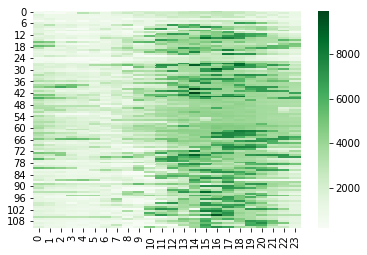

In [68]:
sns.heatmap(pd.DataFrame(test_aggregate[0][0]), cmap='Greens')

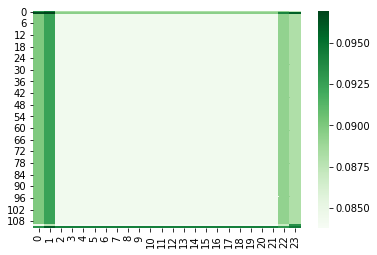

In [82]:
sns.heatmap(pd.DataFrame(train_fold[1600][0].reshape(-1, 112, 24)[5]), cmap='Greens')

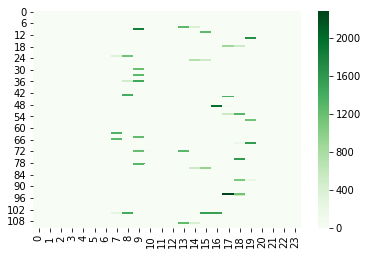

In [83]:
sns.heatmap(pd.DataFrame(train_gt_fold[0].reshape(-1, 112, 24)[5]), cmap='Greens')

In [75]:
def onoff_error(pred, gt, threshold):
    abs_error = np.abs(pred-gt)
    error = [x for x in abs_error.reshape(1, -1).tolist()[0] if x >= threshold]
    
    return np.mean(error)

In [77]:
for t in range(200, num_iterations+1, 200):

    print(t, onoff_error(test_fold[t][0], test_gt_fold[0], 18))

200 1100.26056066
400 1100.24719467
600 1092.43778824
800 1100.18988694
1000 1100.21025543
1200 1100.25972182
1400 1100.26066377
1600 1100.17578339


In [49]:
train_gt_fold[2]

array([[ 0.2       ,  0.26666668,  0.2       , ...,  1.41666663,
         1.26666665,  2.6833334 ],
       [ 1.64999998,  1.36666667,  0.64999998, ...,  0.33333334,
         1.64999998,  1.68333328],
       [ 0.63333333,  0.55000001,  0.98333335, ...,  1.63333333,
         0.64999998,  0.66666669],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.2       ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [47]:
train_fold[200][2]

array([[ 0.        ,  0.        ,  0.        , ...,  0.00033851,
         0.        ,  0.        ],
       [ 0.00239093,  0.00081312,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.0097909 ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00337324,  0.        ,  0.00121355, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.0051079 ]], dtype=float32)

In [37]:
pd.DataFrame(test_error)

,200,400,600,800,1000,1200,1400,1600,1800,2000
dr,71.004390,71.168054,72.256811,74.267883,76.755139,77.602587,78.730931,79.122479,79.205312,79.504459
dw,19.549013,19.556208,19.538995,19.558140,19.540490,19.538111,19.538131,19.537917,19.552066,19.537951
fridge,30.020225,31.739404,33.176804,34.401962,35.232226,35.295100,35.884477,36.351166,36.610283,36.548123
hvac,345.626050,332.520962,326.693016,329.828265,336.977560,335.423433,338.235341,343.442527,343.997589,344.967933
mw,6.838494,7.412712,7.580235,7.464459,7.741110,8.077630,8.831316,9.520062,9.599482,9.821674


In [14]:
test_error

{1000: {'dr': 104.51486100150184,
  'dw': 11.024693286003417,
  'fridge': 43.628079512353146,
  'hvac': 170.66594519918587,
  'mw': 7.1834119964077372},
 2000: {'dr': 132.7653845653841,
  'dw': 11.024307860026147,
  'fridge': 47.901991705041326,
  'hvac': 181.09079424734418,
  'mw': 7.1065447021710924},
 3000: {'dr': 139.08151216003162,
  'dw': 11.024774495282799,
  'fridge': 47.871046935981276,
  'hvac': 183.52738505555899,
  'mw': 7.2129953022498627},
 4000: {'dr': 143.52523411012223,
  'dw': 11.024311092145034,
  'fridge': 47.957222381518989,
  'hvac': 183.53725180561787,
  'mw': 7.3162178633638364},
 5000: {'dr': 147.3578787644916,
  'dw': 11.024311247478749,
  'fridge': 46.48262682793203,
  'hvac': 182.57096604425192,
  'mw': 7.3999224717760086},
 6000: {'dr': 149.68912326295776,
  'dw': 11.024307778145825,
  'fridge': 47.255146366351035,
  'hvac': 181.87193982892714,
  'mw': 7.3724442526361926},
 7000: {'dr': 151.1437072533798,
  'dw': 11.024307853860456,
  'fridge': 46.717229327